In [5]:
import pandas as pd

raw_df = pd.read_csv("US_Accidents_March23.csv")

In [216]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

US_STATES = {
    "AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA",
    "ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK",
    "OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY","DC"
}

def clean_us_accidents(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Remove whitespaces in strings
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    for c in obj_cols:
        df[c] = df[c].astype("string").str.strip()
        
    # Drop rows with duplicated IDs
    if "ID" in df.columns:
        df["ID"] = df["ID"].astype("string")
        df = df.drop_duplicates(subset=["ID"])
        
    # Remove redundant columns
    cols_to_drop = ["ID", "Source", "Zipcode", "Timezone", "Airport_Code", "End_Lat", "End_Lng"]
    df = df.drop(columns=cols_to_drop, errors="ignore")
    
    # Replace wrong/missing values as NaT
    for c in ["Start_Time", "End_Time", "Weather_Timestamp"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")

    # Remove rows with missing start time values
    df = df[df["Start_Time"].notna()]
    
    def remove_out_of_bounds_values(col, lo=None, hi=None):
        if col not in df.columns:
            return
        
        df[col] = pd.to_numeric(df[col], errors="coerce")
        if lo is not None:
            df.loc[df[col] < lo, col] = np.nan
        if hi is not None:
            df.loc[df[col] > hi, col] = np.nan
            
    # Remove out of bounds values for severity
    remove_out_of_bounds_values("Severity", 1, 4)
    df["Severity"] = df["Severity"].round().astype("Int64")

    # Remove out of bounds values for coordinates
    remove_out_of_bounds_values("Start_Lat", -90, 90)
    remove_out_of_bounds_values("Start_Lng", -180, 180)
    
    # Remove missing Start_Lat or Start_Lng rows
    df = df[df["Start_Lat"].notna() & df["Start_Lng"].notna()]
    
    # Set all in State to capital letters and set states which are not in US_STATES to NA
    df["State"] = df["State"].astype("string").str.upper()
    df.loc[~df["State"].isin(US_STATES), "State"] = pd.NA
    df["State"] = df["State"].astype("category")
    
    # Remove out of bounds values for weather measurements 
    remove_out_of_bounds_values("Temperature(F)", -70, 130) 
    remove_out_of_bounds_values("Wind_Chill(F)", -50, 130) 
    remove_out_of_bounds_values("Humidity(%)", 0, 100) 
    remove_out_of_bounds_values("Pressure(in)", 15, 32)
    remove_out_of_bounds_values("Visibility(mi)", 0, 100) 
    remove_out_of_bounds_values("Wind_Speed(mph)", 0, 200) 
    remove_out_of_bounds_values("Precipitation(in)", 0, 50)
    
    # Handle missing values in weather_num using iterative imputer method
    weather_num = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
               "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
    imp = IterativeImputer(random_state=0, max_iter=10)
    df[weather_num] = imp.fit_transform(df[weather_num])

    # Standarize wind directions
    df["Wind_Direction"] = df["Wind_Direction"].astype("string").str.strip().str.upper()
    df["Wind_Direction"] = df["Wind_Direction"].replace({
        "VARIABLE": "VAR",
        "VAR": "VAR",
        "CALM": "CALM",
        "NORTH": "N",
        "SOUTH": "S",
        "EAST": "E",
        "WEST": "W",
    })
    df["Wind_Direction"] = df["Wind_Direction"].astype("category")

    # Normalise all the columns in twlight_cols to Day/Night/Unknown
    twilight_cols = ["Sunrise_Sunset","Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"]
    for c in twilight_cols:
        df[c] = df[c].astype("string").str.strip().str.title()
        df.loc[~df[c].isin(["Day","Night"]), c] = "Unknown"
        df[c] = df[c].astype("category")

    bool_cols = [
        "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
        "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
    ]
    for c in bool_cols:
        if c not in df.columns:
            continue
        
        # Handle the case where the boolean is a string
        if df[c].dtype.name in ["string", "object"]:
            df[c] = df[c].str.lower().map({"true": True, "false": False})
        df[c] = df[c].astype("boolean")

        # Assume all misisng boolean values to be false
        df[c] = df[c].fillna(False)

    return df

In [234]:
df = clean_us_accidents(raw_df)
df.isna().sum()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
Distance(mi)                  0
Description                   5
Street                     8474
City                        226
County                        0
State                         0
Country                       0
Weather_Timestamp        106209
Temperature(F)                0
Wind_Chill(F)                 0
Humidity(%)                   0
Pressure(in)                  0
Visibility(mi)                0
Wind_Direction           153449
Wind_Speed(mph)               0
Precipitation(in)             0
Weather_Condition        155462
Amenity                       0
Bump                          0
Crossing                      0
Give_Way                      0
Junction                      0
No_Exit                       0
Railway                       0
Roundabout                    0
Station                       0
Stop    

In [235]:
print(df.columns)

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State',
       'Country', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [ ]:
def remove_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lo = Q1 - 1.5 * IQR
    hi = Q3 + 1.5 * IQR

    df.loc[df[col] < lo, col] = np.nan
    df.loc[df[col] > hi, col] = np.nan
    
# Remove outlier values for weather measurements 
remove_outliers("Temperature(F)") 
remove_outliers("Wind_Chill(F)") 
remove_outliers("Humidity(%)") 
remove_outliers("Pressure(in)")
remove_outliers("Wind_Speed(mph)") 
remove_outliers("Precipitation(in)")

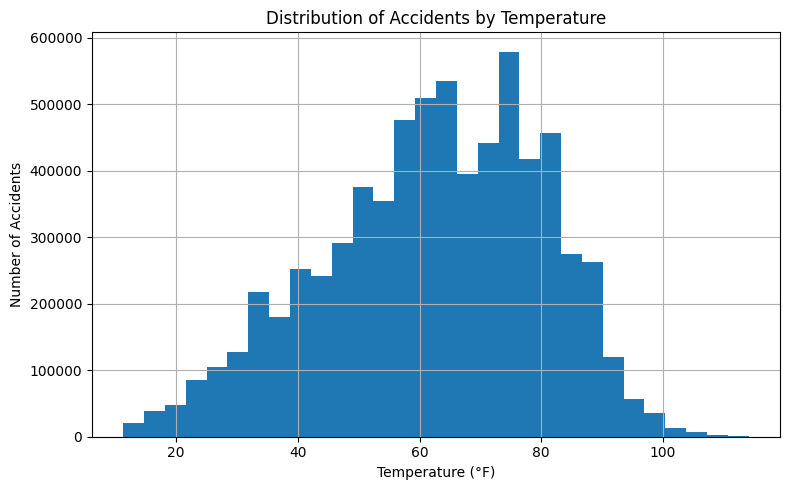

In [237]:
# 'Temperature(F)'
import matplotlib.pyplot as plt

df['Temperature(F)'].hist(bins=30, figsize=(8, 5))
plt.xlabel('Temperature (°F)')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents by Temperature')
plt.tight_layout()
plt.show()

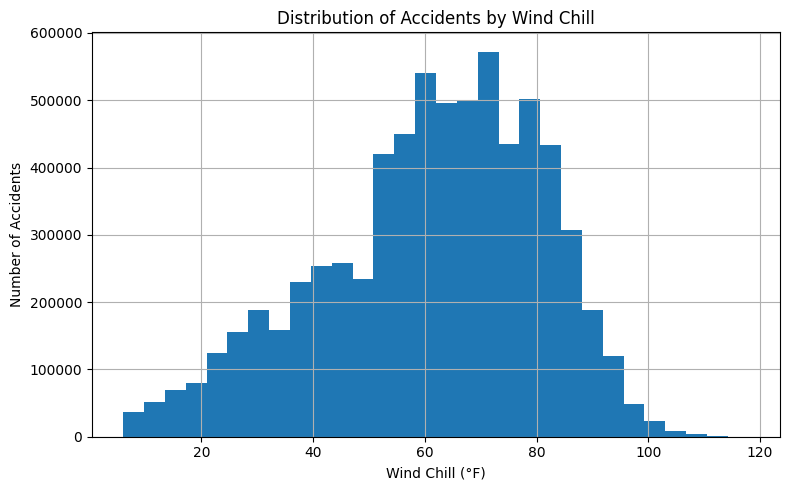

In [238]:
# 'Wind_Chill(F)'
df['Wind_Chill(F)'].hist(bins=30, figsize=(8, 5))
plt.xlabel('Wind Chill (°F)')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents by Wind Chill')
plt.tight_layout()
plt.show()

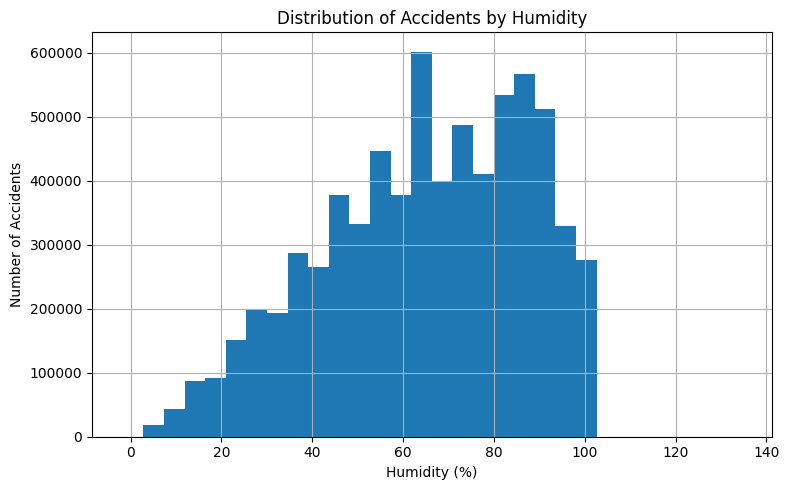

In [239]:
# 'Humidity(%)'
df['Humidity(%)'].hist(bins=30, figsize=(8, 5))
plt.xlabel('Humidity (%)')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents by Humidity')
plt.tight_layout()
plt.show()

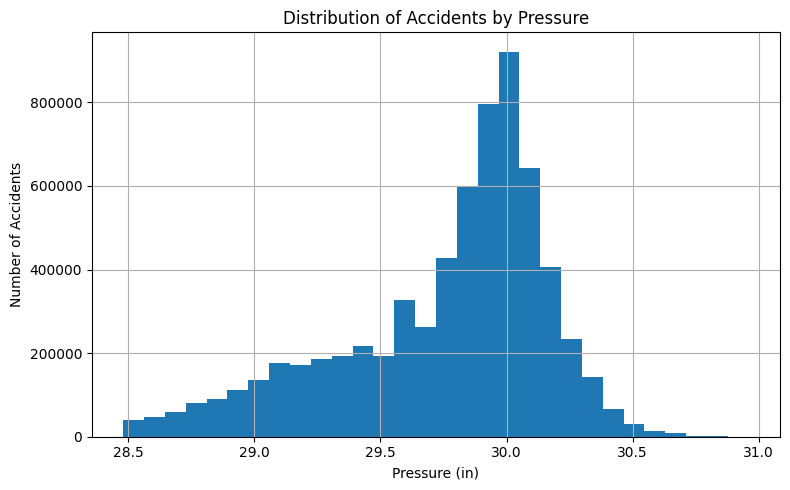

In [240]:
# 'Pressure(in)'
df['Pressure(in)'].hist(bins=30, figsize=(8, 5))
plt.xlabel('Pressure (in)')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents by Pressure')
plt.tight_layout()
plt.show()

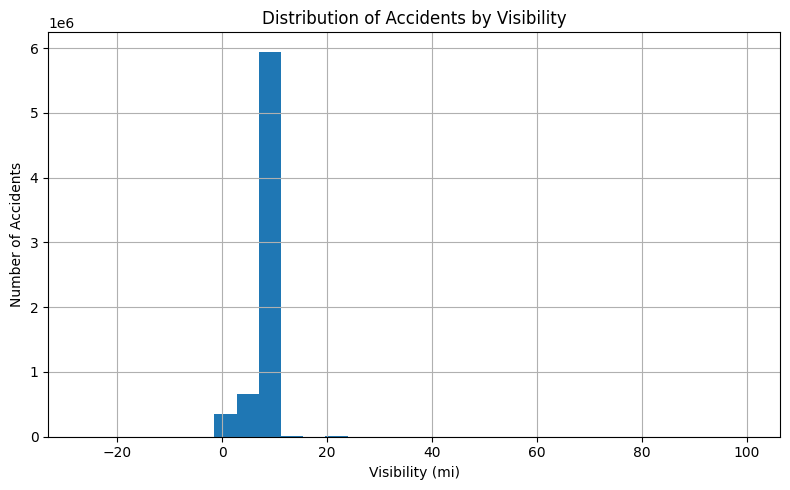

In [246]:
# 'Visibility(mi)'
df['Visibility(mi)'].hist(bins=30, figsize=(8, 5))
plt.xlabel('Visibility (mi)')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents by Visibility')
plt.tight_layout()
plt.show()

In [245]:
wind_direction = (
    dt['Wind_Direction']
    .value_counts()
    .sort_values(ascending=False)
)

wind_direction

Wind_Direction
CALM    1209347
S        541957
W        494545
N        419741
SSW      348777
E        343801
WNW      340516
NW       332102
SW       329762
VAR      329533
WSW      319056
SSE      316492
NNW      300430
SE       265631
ESE      240416
NE       234144
ENE      233350
NNE      232179
Name: count, dtype: int64

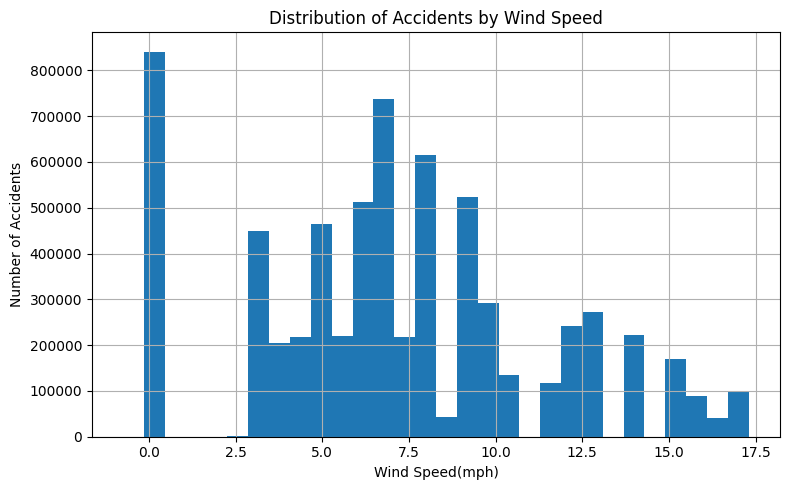

In [247]:
# 'Wind_Speed(mph)'
df['Wind_Speed(mph)'].hist(bins=30, figsize=(8, 5))
plt.xlabel('Wind Speed(mph)')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents by Wind Speed')
plt.tight_layout()
plt.show()

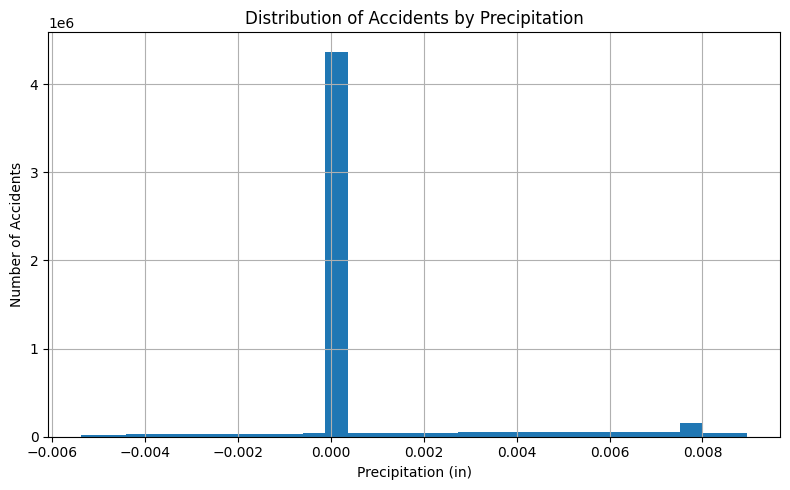

In [248]:
# 'Precipitation(in)'
df['Precipitation(in)'].hist(bins=30, figsize=(8, 5))
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents by Precipitation')
plt.tight_layout()
plt.show()
    

In [249]:
# 'Weather_Condition'
weather_condition = (
    dt['Weather_Condition']
    .value_counts()
    .sort_values(ascending=False)
)

weather_condition

Weather_Condition
Fair                         2206054
Mostly Cloudy                 923515
Clear                         808231
Cloudy                        715030
Partly Cloudy                 635456
                              ...   
Heavy Sleet and Thunder            1
Heavy Sleet / Windy                1
Sand / Windy                       1
Heavy Rain Shower / Windy          1
Drifting Snow                      1
Name: count, Length: 143, dtype: Int64

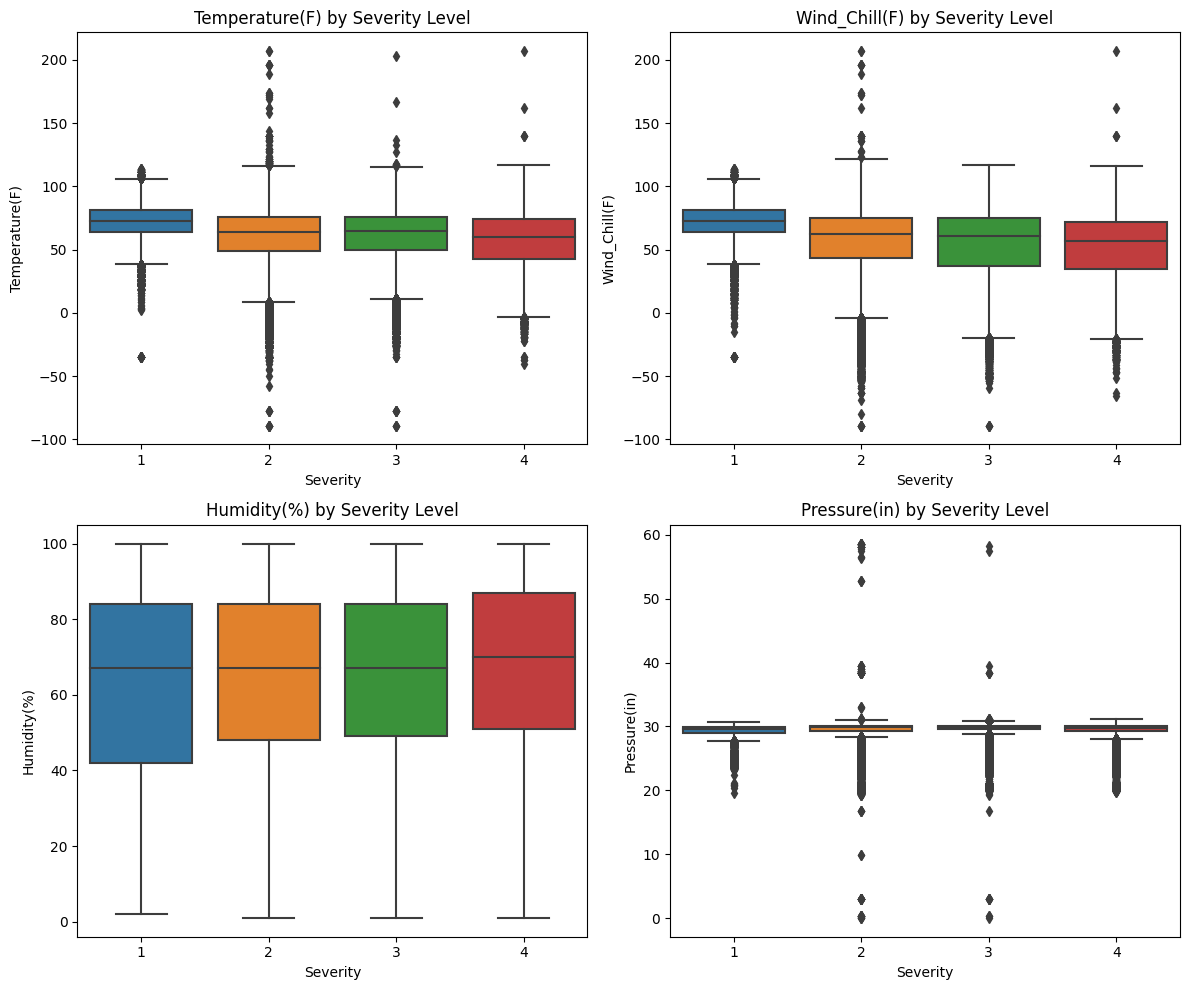

In [250]:
# Box-plot with severity
import seaborn as sns
weather_cols = [
    'Temperature(F)', 'Wind_Chill(F)',
    'Humidity(%)', 'Pressure(in)', 
    'Visibility(mi)', 'Wind_Speed(mph)', 
    'Precipitation(in)'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, var in zip(axes.flatten(), weather_cols):
    sns.boxplot(x='Severity', y=var, data=raw_df, ax=ax)
    ax.set_title(f'{var} by Severity Level')
    ax.set_xlabel('Severity')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()